In [1]:
from models.training import Trainer
from models.base_model import GMF
from models.advanced_model import MLP
from evaluation.evaluator import Evaluator
from prediction.predict import predict
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns

In [25]:
sessions_train_df = pd.read_json('data_files/train_sessions.jsonl', lines=True)
sessions_val_df = pd.read_json('data_files/val_sessions.jsonl', lines=True)
begin = 500
end = 1000
unique_users_count = 3000
unique_tracks_count = 12303
users_range = np.arange(2000, 2500)
tracks_range = np.arange(unique_tracks_count)
df = pd.DataFrame(
    product(users_range, tracks_range),
    columns=['user_id', 'track_id']
)
sessions_train_df = df.merge(
    sessions_train_df[['user_id', 'track_id', 'score']], 
    on=['user_id', 'track_id'], 
    how='left'
).fillna(0)
sessions_val_df = df.merge(
    sessions_val_df[['user_id', 'track_id', 'score']], 
    on=['user_id', 'track_id'], 
    how='left'
).fillna(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
sessions_train_df['preference'] = sessions_train_df['score'] >= 1
sessions_val_df['preference'] = sessions_val_df['score'] >= 1

In [28]:
alpha = 40
epsilon = 1e-8
sessions_train_df['weight'] = 1 + alpha * np.log(1 + sessions_train_df['score'] / epsilon)
sessions_val_df['weight'] = 1 + alpha * np.log(1 + sessions_val_df['score'] / epsilon)

In [29]:
train_dataset = torch.utils.data.TensorDataset(
    torch.LongTensor(sessions_train_df['user_id'].values),
    torch.LongTensor(sessions_train_df['track_id'].values),
    torch.FloatTensor(sessions_train_df['preference'].values),
    torch.FloatTensor(sessions_train_df['weight'].values)
)

val_dataset = torch.utils.data.TensorDataset(
    torch.LongTensor(sessions_val_df['user_id'].values),
    torch.LongTensor(sessions_val_df['track_id'].values),
    torch.FloatTensor(sessions_val_df['preference'].values),
    torch.FloatTensor(sessions_val_df['weight'].values)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False
)

In [6]:
model = GMF(unique_users_count, unique_tracks_count, embedding_dim=32, dropout_rate=0.0, init=True, bias=False, sigmoid=False)

In [5]:
hid_layers_dim = [256, 128, 64, 32]
model = MLP(unique_users_count, unique_tracks_count, 128, hid_layers_dim, 0.0, True)

In [30]:
trainer = Trainer(model, train_loader, val_loader, device)
train_loss, val_loss = trainer.train_with_weight_decay(
    epochs=15,
    learning_rate=0.005,
    weight_decay=0.005
)

Epoch: 0; Train loss: 3.804932454948965; Val loss: 0.8090973803506102
Epoch: 1; Train loss: 1.6519245958891304; Val loss: 0.800566342489773
Epoch: 2; Train loss: 1.643830262912694; Val loss: 0.8037225621934985
Epoch: 3; Train loss: 1.654763047364271; Val loss: 0.8150446843427206
Epoch: 4; Train loss: 1.672525437911054; Val loss: 0.8077981565902618
Epoch: 5; Train loss: 1.6641010985615547; Val loss: 0.8079613515580886
Epoch: 6; Train loss: 1.661646889333074; Val loss: 0.8090749066405206
Epoch: 7; Train loss: 1.6695108542008743; Val loss: 0.821301455109927
Epoch: 8; Train loss: 1.675992578982414; Val loss: 0.804813453403336
Epoch: 9; Train loss: 1.669879688147054; Val loss: 0.8026111211134737
Epoch: 10; Train loss: 1.6579357676787818; Val loss: 0.8052436367019893
Epoch: 11; Train loss: 1.6679020661589408; Val loss: 0.8065575371449484
Epoch: 12; Train loss: 1.6688163659967485; Val loss: 0.8039280863637682
Epoch: 13; Train loss: 1.6674864062482102; Val loss: 0.7995113921581558
Epoch: 14; T

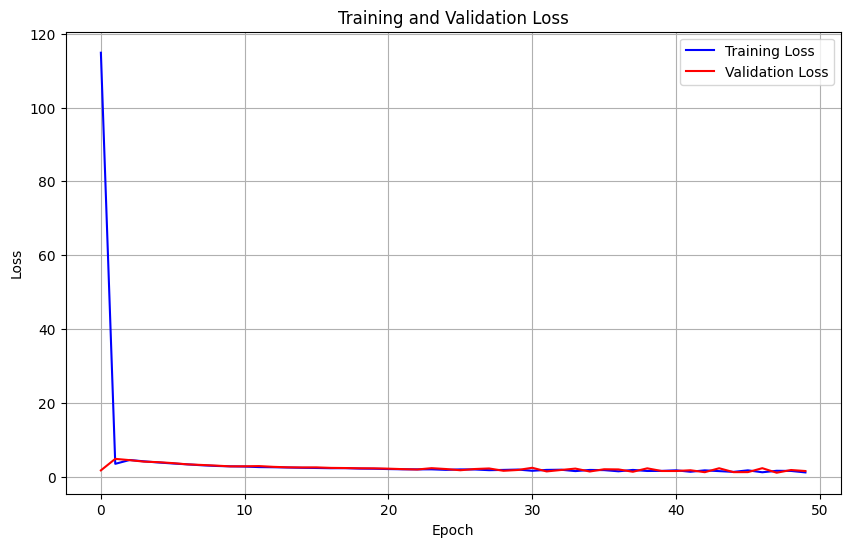

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, 'b-', label='Training Loss')
plt.plot(val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
torch.save(model.state_dict(), './model_files/model3.pth')

In [7]:
model.load_state_dict(torch.load('./model_files/model1.pth', map_location=device))

<All keys matched successfully>

In [10]:
user_norms = torch.norm(model.user_embedding.weight, dim=1)
avg_user_norm = torch.mean(user_norms) 
item_norms = torch.norm(model.item_embedding.weight, dim=1)
avg_item_norm = torch.mean(item_norms)

print(model.item_embedding.weight[0])
print("Średnia norma user embeddings:", avg_user_norm.item())
print("Średnia norma item embeddings:", avg_item_norm.item())

tensor([-0.2975,  0.1719,  0.5525, -0.2353, -0.3203,  0.2541, -0.0467, -0.4057,
         0.1358, -0.3619, -0.1183, -0.2540,  0.1203,  0.3870,  0.4417, -0.2015,
         0.0627,  0.1000, -0.1896, -0.1299,  0.2733, -0.0700, -0.1029,  0.1910,
         0.1620, -0.0775, -0.1555,  0.2747, -0.3196,  0.0200, -0.3238, -0.0218],
       device='cuda:0', grad_fn=<SelectBackward0>)
Średnia norma user embeddings: 1.7055904865264893
Średnia norma item embeddings: 1.4270309209823608


In [11]:
sessions_val_df['score_pred'] = predict(model, val_loader, device)
sessions_train_df['score_pred'] = predict(model, train_loader, device)

In [12]:
pd.set_option('display.min_rows', 5000)
pd.set_option('display.max_rows', 5000)

In [13]:
display(sessions_train_df)

,user_id,track_id,score,preference,weight,score_pred
0,0,0,0.0,False,1.000000,0.122485
1,0,1,0.0,False,1.000000,-0.153444
2,0,2,0.0,False,1.000000,-0.195784
3,0,3,0.0,False,1.000000,1.226911
4,0,4,0.0,False,1.000000,0.062254
5,0,5,0.0,False,1.000000,0.347805
6,0,6,0.0,False,1.000000,-0.017704
7,0,7,0.0,False,1.000000,0.051044
8,0,8,0.0,False,1.000000,0.999055
9,0,9,0.0,False,1.000000,-0.162769


In [16]:
true_ = sessions_train_df[sessions_train_df['preference'] == True]['score_pred'].mean() 
false_ = sessions_train_df[sessions_train_df['preference'] == False]['score_pred'].mean()

In [17]:
print(true_, false_)

0.29430056 0.29720363


In [13]:
random_ids = np.random.choice(3000, size=50, replace=False)
selected_train_df = sessions_train_df[sessions_train_df['user_id'].isin(random_ids)]
selected_val_df = sessions_val_df[sessions_val_df['user_id'].isin(random_ids)]

In [45]:
evaluator2 = Evaluator([5, 10, 30, 40, 50], 0.9)

In [46]:
metrics = evaluator2.evaluate(sessions_train_df)

In [24]:
for metric, value in metrics.items():
    print(f'{metric}: {value * 100}%')

Recall@100: user_id
0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
5        0.000000
6        0.000000
7        0.000000
8        0.000000
9        0.000000
10       0.000000
11       0.000000
12       0.000000
13     100.000000
14       0.000000
15       0.000000
16       0.000000
17       0.000000
18       0.000000
19       0.000000
20       0.000000
21       0.000000
22       0.000000
23       0.000000
24       0.000000
25       0.000000
26      96.428571
27       0.000000
28       0.000000
29       0.000000
30       0.000000
31       0.000000
32       0.000000
33       0.000000
34      79.245283
35       0.000000
36       0.000000
37       0.000000
38       0.000000
39      52.830189
40       0.000000
41      81.250000
42       0.000000
43       0.000000
44      83.561644
45       0.000000
46      77.272727
47       0.000000
48      40.000000
49       0.000000
50       0.000000
51      88.059701
52       0.000000
53       0.000000
54      

In [47]:
metrics_df = pd.DataFrame({
    'Precision@5': metrics['Precision@5'],
    'Precision@10': metrics['Precision@10'],
    'Precision@30': metrics['Precision@30'],
    'Precision@40': metrics['Precision@40'],
    'Precision@50': metrics['Precision@50'],
    'Recall@5': metrics['Recall@5'],
    'Recall@10': metrics['Recall@10'],
    'Recall@30': metrics['Recall@30'],
    'Recall@40': metrics['Recall@40'],
    'Recall@50': metrics['Recall@50'],
})
display(metrics_df)

,Precision@5,Precision@10,Precision@30,Precision@40,Precision@50,Recall@5,Recall@10,Recall@30,Recall@40,Recall@50
user_id,,,,,,,,,,
0,0.0,0.0,0.000000,0.000,0.02,0.000000,0.000000,0.000000,0.000000,0.001972
1,0.2,0.1,0.066667,0.050,0.04,0.002439,0.002439,0.004878,0.004878,0.004878
2,0.0,0.0,0.033333,0.025,0.04,0.000000,0.000000,0.001070,0.001070,0.002139
3,0.0,0.0,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.033333,0.025,0.02,0.000000,0.000000,0.005348,0.005348,0.005348
5,0.0,0.0,0.000000,0.000,0.02,0.000000,0.000000,0.000000,0.000000,0.002488
6,0.0,0.1,0.033333,0.075,0.08,0.000000,0.001828,0.001828,0.005484,0.007313
7,0.0,0.0,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.0,0.0,0.033333,0.025,0.02,0.000000,0.000000,0.004464,0.004464,0.004464


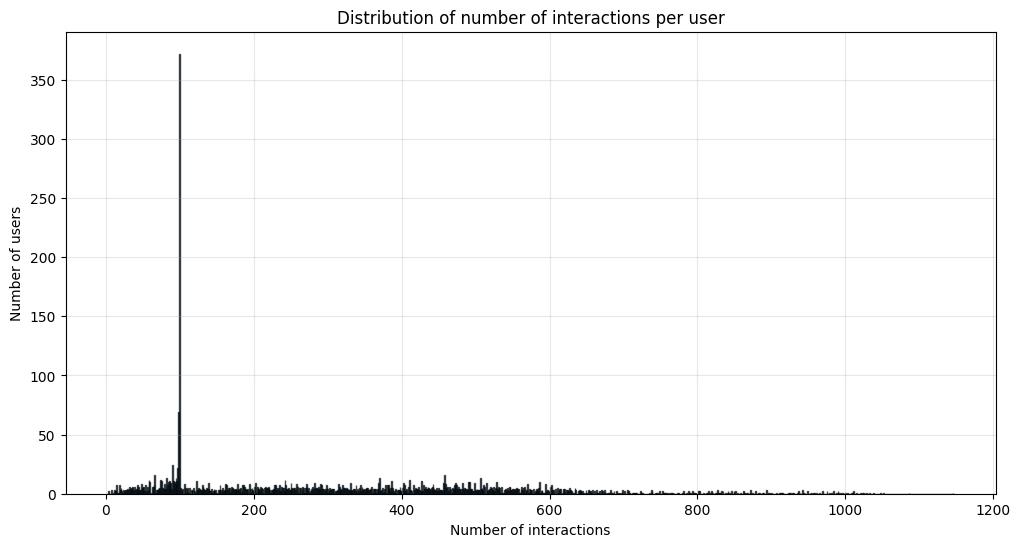

In [32]:
user_interactions = sessions_train_df.groupby('user_id')['track_id'].count()

plt.figure(figsize=(12, 6))
plt.hist(user_interactions, bins=1000, edgecolor='black', alpha=0.7)
plt.title('Distribution of number of interactions per user')
plt.xlabel('Number of interactions')
plt.ylabel('Number of users')
plt.grid(True, alpha=0.3)

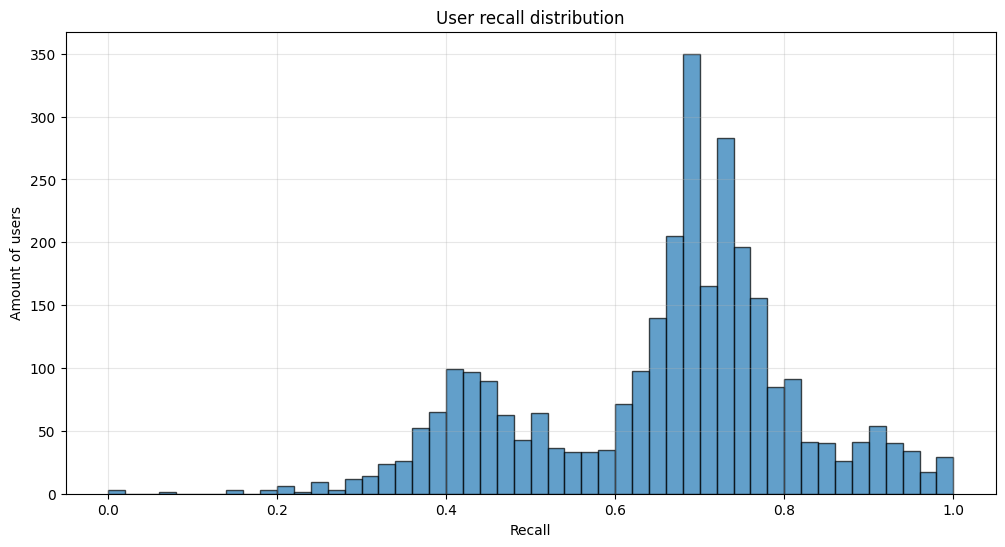

In [33]:
plt.figure(figsize=(12, 6))
plt.hist(metrics['Precision@100'], bins=50, edgecolor='black', alpha=0.7)
plt.title('User recall distribution')
plt.xlabel('Recall')
plt.ylabel('Amount of users')
plt.grid(True, alpha=0.3)

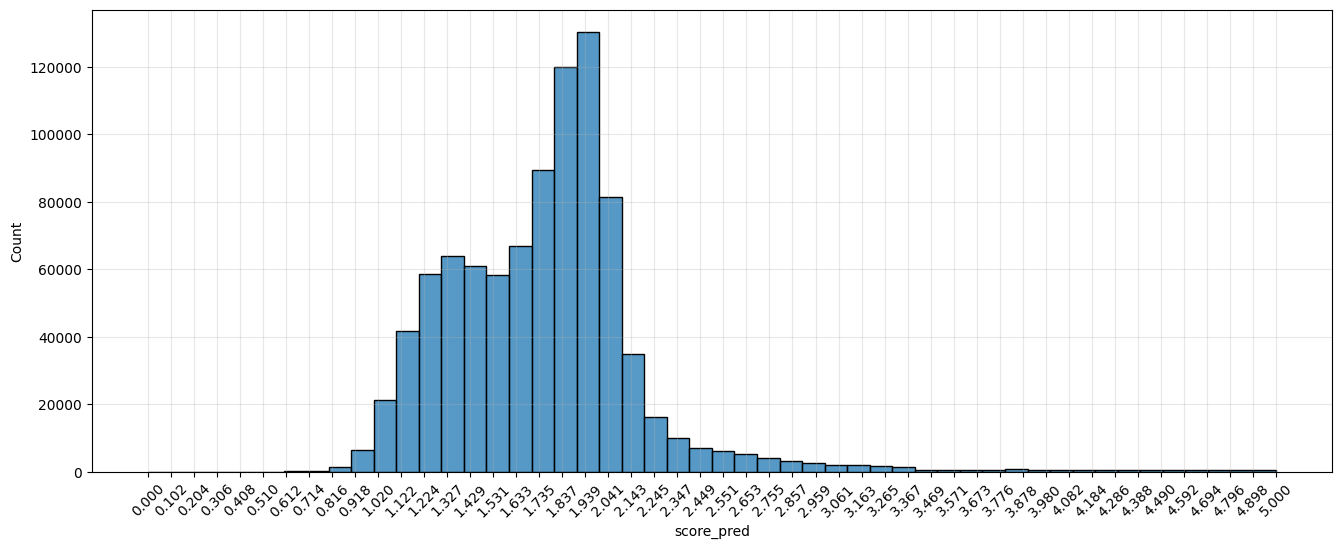

In [10]:
zoom_max = 5.0
ticks = 50
filtered_df = sessions_train_df[sessions_train_df['score_pred'] < zoom_max]

plt.figure(figsize=(16, 6))
sns.histplot(data=filtered_df, x='score_pred', bins=50)
plt.grid(True, alpha=0.3)

x_min = filtered_df['score_pred'].min()
x_max = zoom_max
x_ticks = np.linspace(x_min, x_max, ticks)
plt.xticks(x_ticks, rotation=45)

plt.show()

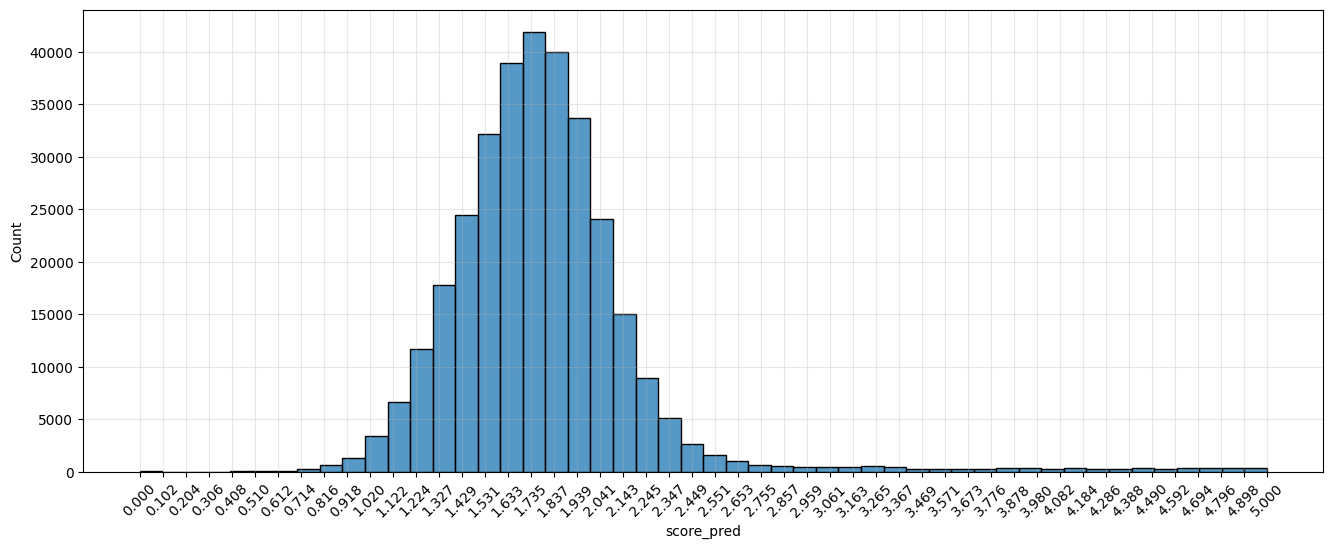

In [11]:
zoom_max = 5.0
ticks = 50
filtered_df = sessions_val_df[sessions_val_df['score_pred'] < zoom_max]

plt.figure(figsize=(16, 6))
sns.histplot(data=filtered_df, x='score_pred', bins=50)
plt.grid(True, alpha=0.3)

x_min = filtered_df['score_pred'].min()
x_max = zoom_max
x_ticks = np.linspace(x_min, x_max, ticks)
plt.xticks(x_ticks, rotation=45)

plt.show()

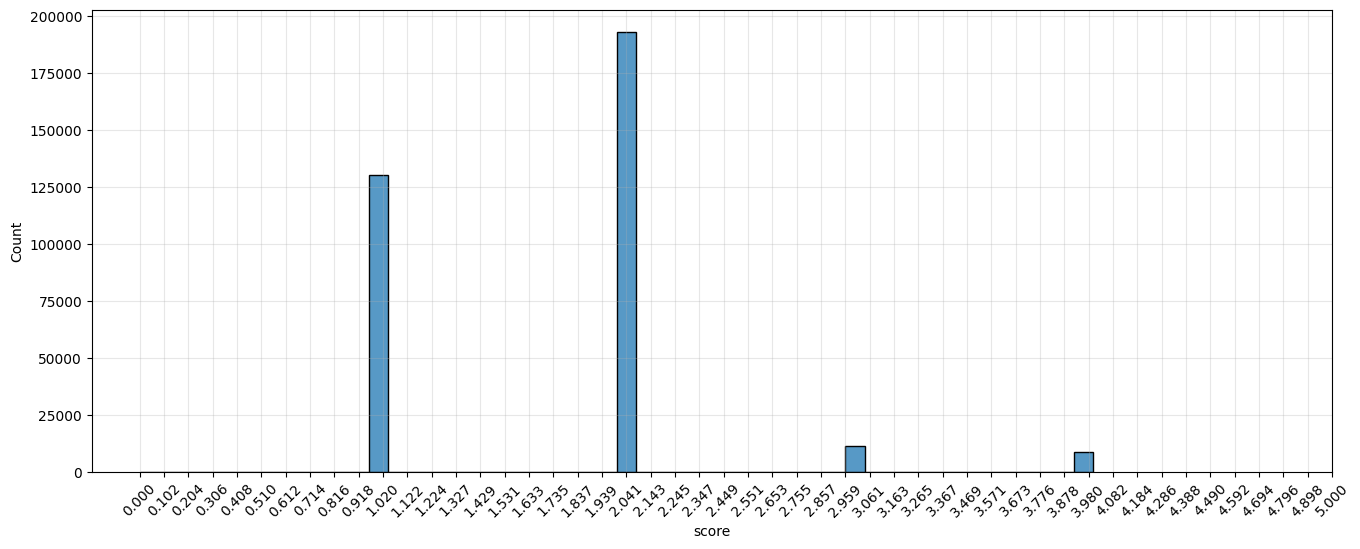

In [49]:
zoom_max = 5.0
ticks = 50
filtered_df = sessions_val_df[sessions_val_df['score'] < zoom_max]

plt.figure(figsize=(16, 6))
sns.histplot(data=filtered_df, x='score', bins=50)
plt.grid(True, alpha=0.3)

x_min = filtered_df['score'].min()
x_max = zoom_max
x_ticks = np.linspace(x_min, x_max, ticks)
plt.xticks(x_ticks, rotation=45)

plt.show()

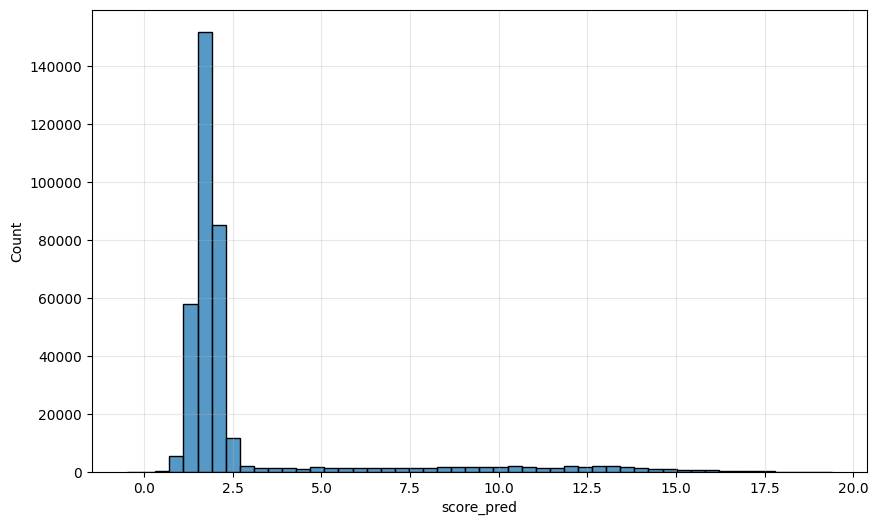

In [37]:
zoom_max = 5.0
ticks = 50
filtered_df = sessions_val_df[sessions_val_df['preference'] < zoom_max]

plt.figure(figsize=(16, 6))
sns.histplot(data=filtered_df, x='score_pred', bins=50)
plt.grid(True, alpha=0.3)

x_min = filtered_df['score_pred'].min()
x_max = zoom_max
x_ticks = np.linspace(x_min, x_max, ticks)
plt.xticks(x_ticks, rotation=45)

plt.show()

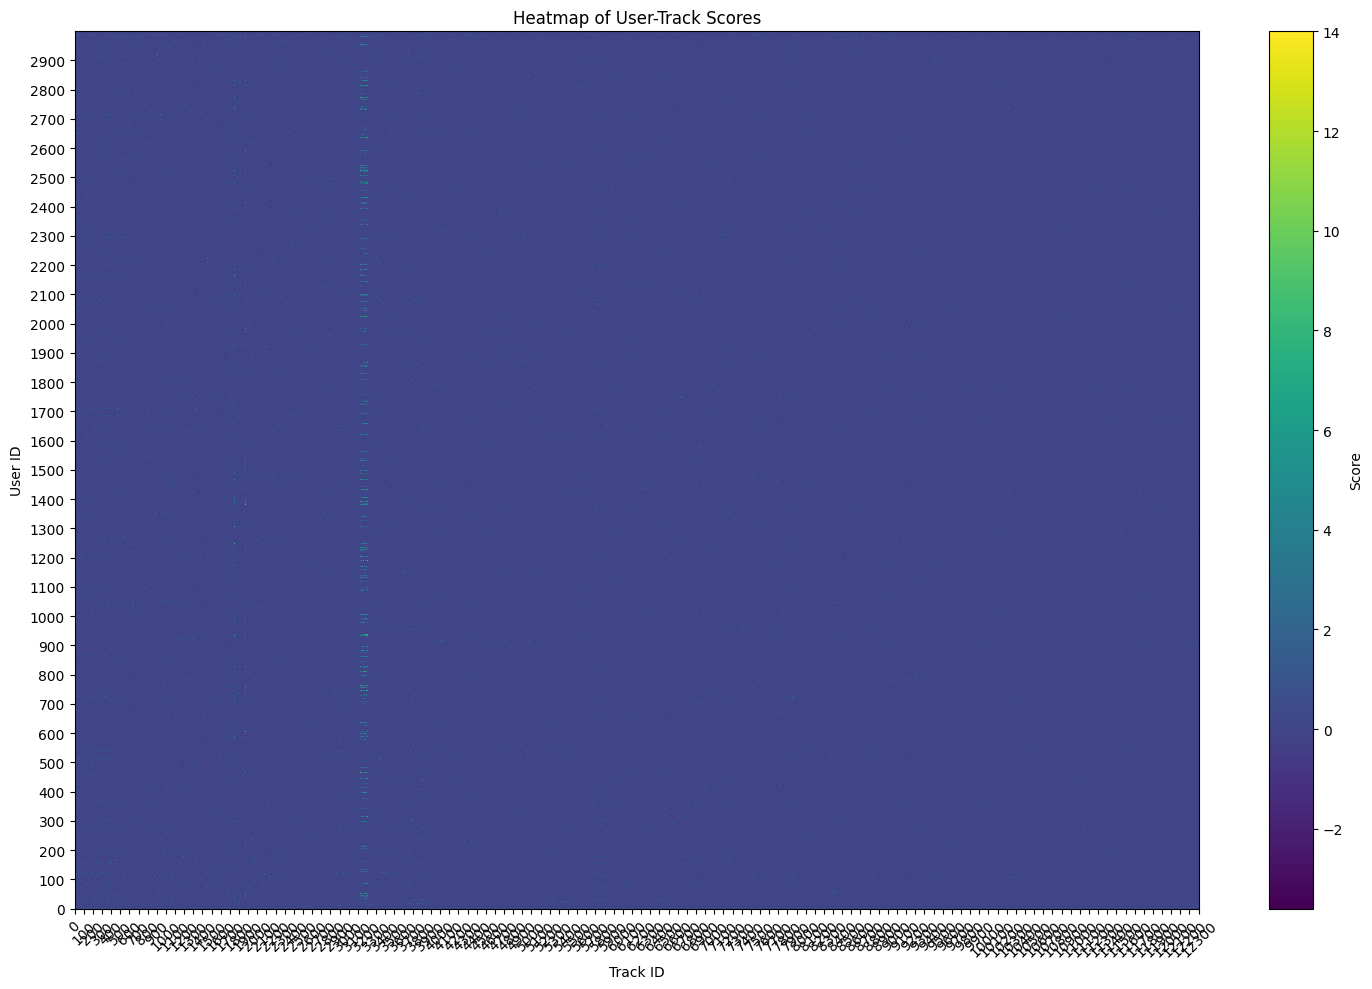

In [3]:
heatmap_data = sessions_train_df.pivot_table(
    values='score',
    index='user_id',
    columns='track_id',
    aggfunc='mean',
    fill_value=0
)

plt.figure(figsize=(15, 10))
plt.pcolormesh(heatmap_data, cmap='viridis')
plt.colorbar(label='Score')
plt.title('Heatmap of User-Track Scores')
plt.xlabel('Track ID')
plt.ylabel('User ID')

plt.xticks(np.arange(0, len(heatmap_data.columns), 100), 
          heatmap_data.columns[::100], 
          rotation=45)
plt.yticks(np.arange(0, len(heatmap_data.index), 100), 
          heatmap_data.index[::100])

plt.tight_layout()

plt.show()

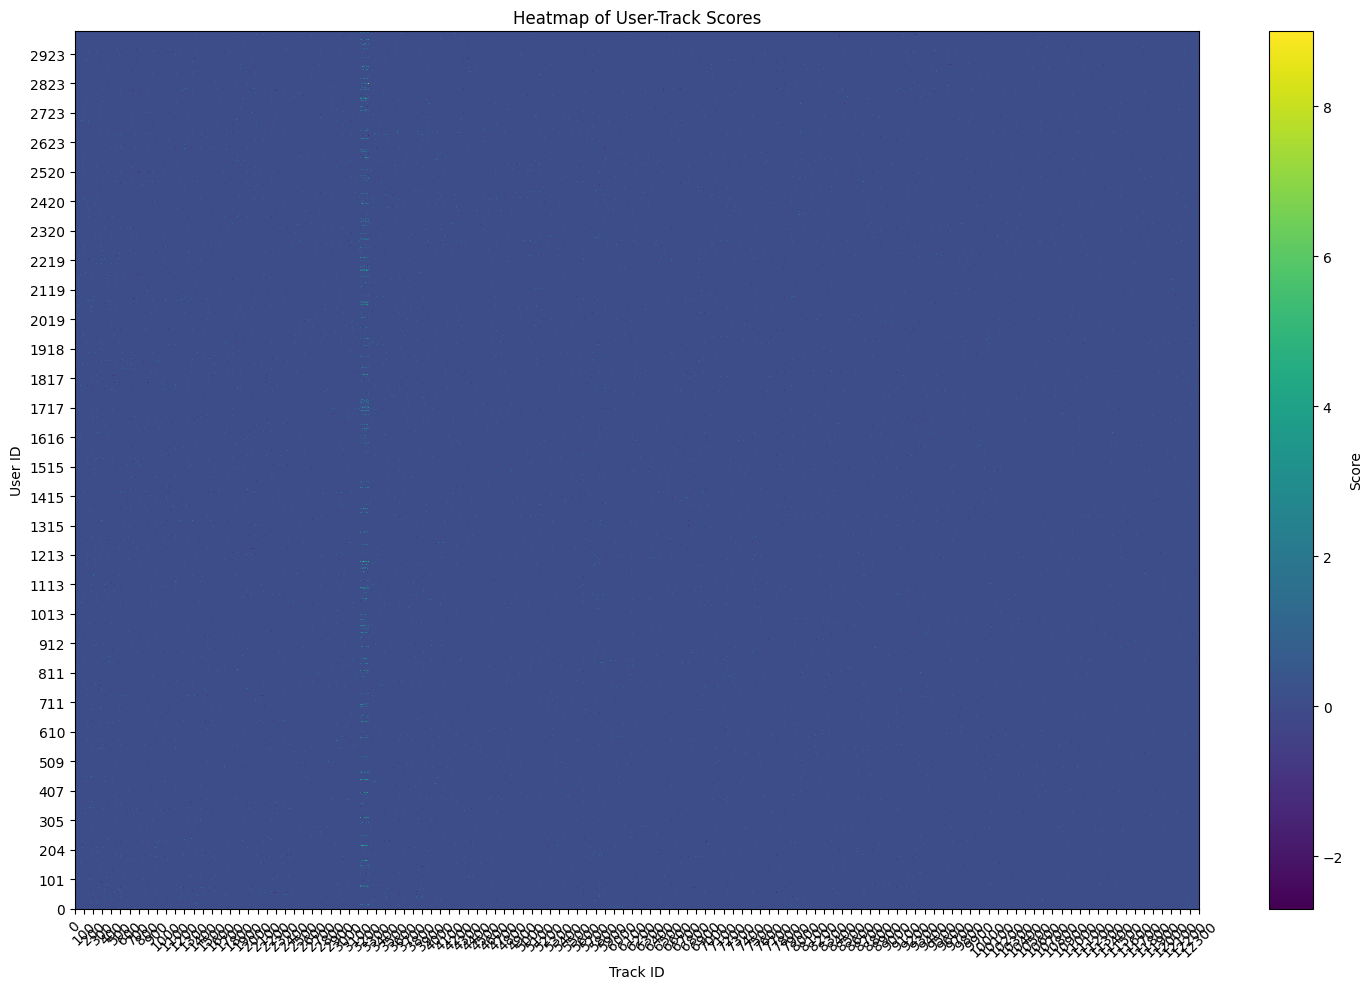

In [3]:
heatmap_data = sessions_val_df.pivot_table(
    values='score',
    index='user_id',
    columns='track_id',
    aggfunc='mean',
    fill_value=0
)

plt.figure(figsize=(15, 10))
plt.pcolormesh(heatmap_data, cmap='viridis')
plt.colorbar(label='Score')
plt.title('Heatmap of User-Track Scores')
plt.xlabel('Track ID')
plt.ylabel('User ID')

plt.xticks(np.arange(0, len(heatmap_data.columns), 100), 
          heatmap_data.columns[::100], 
          rotation=45)
plt.yticks(np.arange(0, len(heatmap_data.index), 100), 
          heatmap_data.index[::100])

plt.tight_layout()

plt.show()